In [1]:
import requests
import urllib.request
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString
import datetime
import random

# Test API with more OD

In [2]:
links = gpd.read_file('../../../Downloads/S1/network/links.geojson')
links.index = 'link_'+links.index.astype(str)

links['time'] = links['length']/links['speedau']
links['time'] = links['time']*3600
#links

In [3]:
nodes = gpd.read_file('../../../Downloads/S1/network/nodes.geojson')

In [4]:
nodes_set = set(links['i'].unique()).union(set(links['j'].unique()))

In [5]:
nodes = nodes[nodes['ID'].isin(nodes_set)]
nodes = nodes.set_index('ID')

In [6]:
random.seed(74)

In [7]:
random_list = random.sample(range(0, len(nodes)), 600)
nodes_test = nodes.iloc[random_list[0:500]]
nodes_train = nodes.iloc[random_list[500:]]
nodes_tot = nodes.iloc[random_list]

<IPython.core.display.Javascript object>


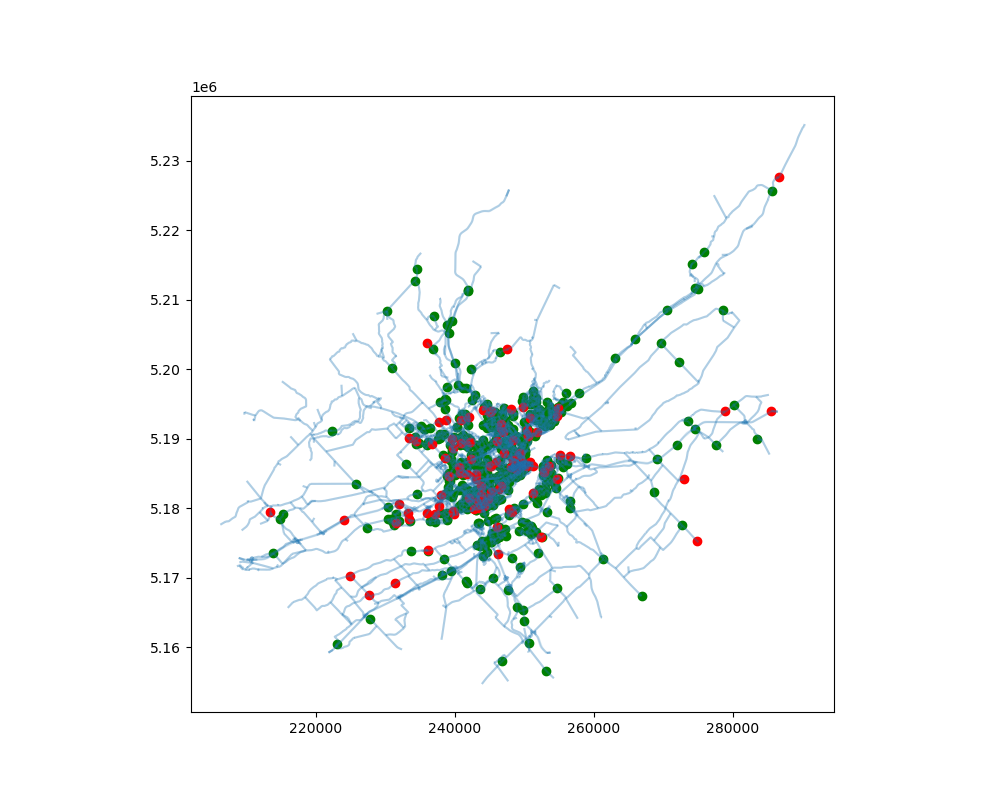

<AxesSubplot: >

In [8]:
%matplotlib notebook
f, ax = plt.subplots(figsize=(10,8))
links.plot(ax=ax,alpha=0.2)
nodes_test.plot(ax=ax,color='g')
nodes_train.plot(ax=ax,color='r')


# OD on road model

In [9]:
from quetzal.engine.road_pathfinder import sparse_matrix, parallel_dijkstra
from scipy.sparse.csgraph import dijkstra

In [10]:
def road_routing(origin,destination,mat,node_index,dijkstra_limit=np.inf):
    # simple routing scipy wrapper for GTFS routing
    #
    index_node = {v: k for k, v in node_index.items()}
    # liste des origines pour le dijkstra
    origin_sparse = [node_index[x] for x in origin]
    
    # dijktra on the road network from node = incices to every other nodes.
    # from b to a.
    dist_matrix, predecessors = dijkstra(
        csgraph=mat,
        directed=True,
        indices=origin_sparse,
        return_predecessors=True,
        limit=dijkstra_limit
    )

    dist_matrix = pd.DataFrame(dist_matrix)
    dist_matrix.index = origin
    # filtrer. on garde seulement les destination d'intéret
    destination_sparse = [node_index[x] for x in destination]
    dist_matrix = dist_matrix[destination_sparse]
    dist_matrix = dist_matrix.rename(columns=index_node)
    
    return dist_matrix

# format data

In [11]:
def format_data(od_time,nodes):
    df = od_time.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'time'})
    geom_dict  = nodes['geometry'].to_dict()
    df['o_geometry'] = df['origin'].apply(lambda x: geom_dict.get(x))
    df['d_geometry'] = df['destination'].apply(lambda x: geom_dict.get(x))
    df['o_lon'] = df['o_geometry'].apply(lambda p: p.x)
    df['o_lat'] = df['o_geometry'].apply(lambda p: p.y)
    df['d_lon'] = df['d_geometry'].apply(lambda p: p.x)
    df['d_lat'] = df['d_geometry'].apply(lambda p: p.y)
    df['distance'] = ((df['o_lon']-df['d_lon'])**2 + (df['o_lat']-df['d_lat'])**2)**0.5
    df['lat_diff'] = df['o_lat']-df['d_lat']
    df['lon_diff'] = df['o_lon']-df['d_lon']
    X = df[['o_lon','o_lat','d_lon','o_lat','distance','lon_diff','lat_diff']]
    Y = df['time']
    return X, Y

In [12]:
mat,indices = sparse_matrix(links[['i','j','time']].values)
od_time_quebec = road_routing(nodes_train.index.values,
             nodes_train.index.values,
             mat,
             indices)
od_time_quebec.mean().mean()/60

23.857659997342928

In [13]:
X_train, y_train = format_data(od_time_quebec,nodes)

In [14]:
mat,indices = sparse_matrix(links[['i','j','time']].values)
od_time_quebec = road_routing(nodes_test.index.values,
             nodes_test.index.values,
             mat,
             indices)
od_time_quebec.mean().mean()/60

23.031248379594523

In [15]:
X_test, y_test = format_data(od_time_quebec,nodes)

In [16]:
print(len(X_test),len(X_train),len(X_train)/len(X_test))

250000 10000 0.04


# using actual OD to train

In [21]:
mat,indices = sparse_matrix(links[['i','j','time']].values)
od_time_quebec = road_routing(nodes_tot.index.values,
             nodes_tot.index.values,
             mat,
             indices)
od_time_quebec.mean().mean()/60
X, y = format_data(od_time_quebec,nodes)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=1-(100*100)/600**2, random_state=42)

In [18]:
len(X_train)**0.5

100.0

# Kriging

In [19]:
from skgstat import OrdinaryKriging, Variogram

In [20]:
from sklearn.model_selection import train_test_split
X = df[['o_lon','o_lat','d_lon','o_lat']]
Y = df['time']

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.96, random_state=42)

NameError: name 'df' is not defined

In [67]:
V = Variogram(X_train.values, y_train,n_lags=20,model='spherical')

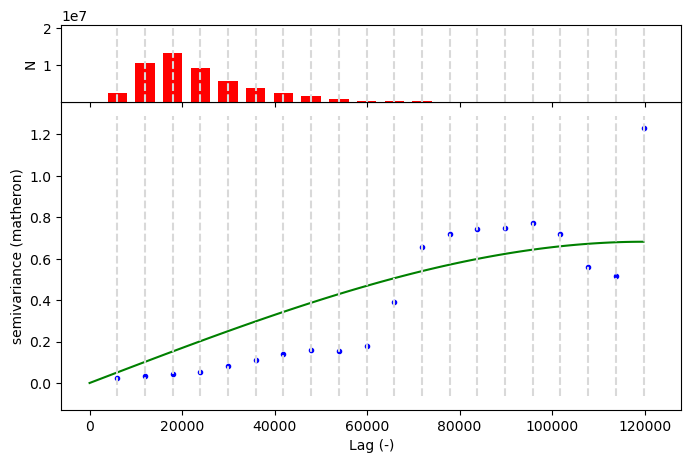

In [81]:
%matplotlib inline
V.plot()
plt.show()

In [69]:
#ok = OrdinaryKriging(V, min_points=1, max_points=20, mode='exact')
ok = OrdinaryKriging(V,mode='exact')

In [79]:
field = ok.transform(X_test.values)


In [ ]:
print(field.max(),y_test.max())

In [385]:
#s2 = ok.sigma.reshape(od_time_quebec2.shape)

In [43]:

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [44]:
x = y_test.values/60
y = field/60

regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0


Text(0.5, 1.0, 'comparaison temps krigeage')

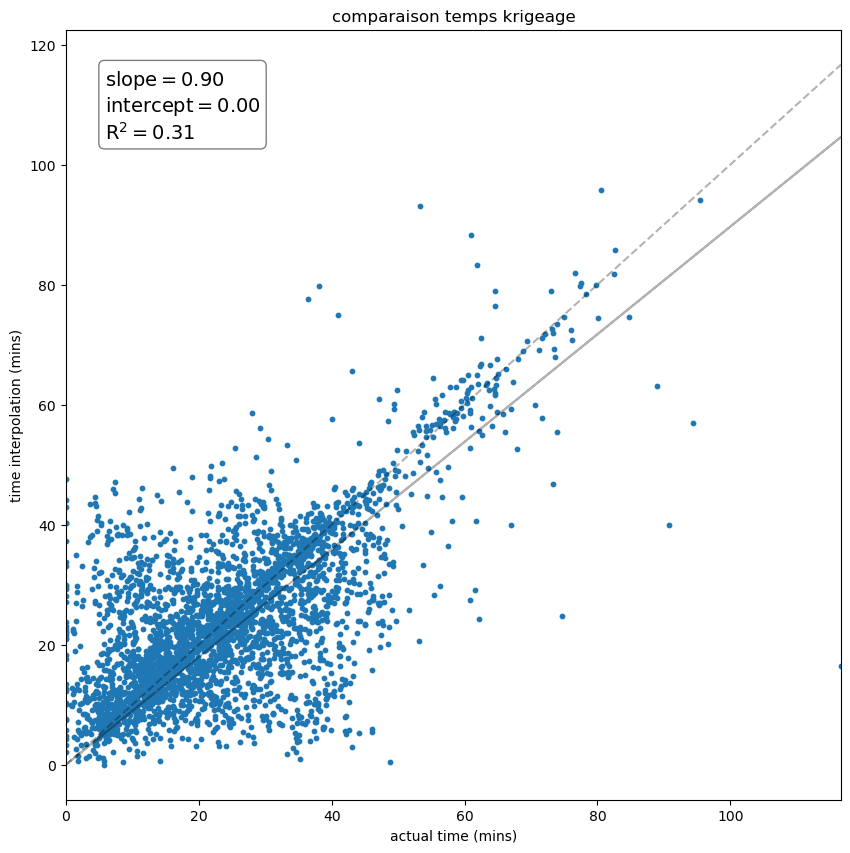

In [45]:
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,alpha=1,s=10)
maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--k',alpha=0.3)
textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'k',alpha=0.3)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps krigeage')
#plt.title('comparaison temps écoulement sur chaque liens '+city +relgap)

# Random Forest

In [22]:

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
%%time
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 200, random_state = 42,max_depth=None)
# Train the model on training data
rf.fit(X_train.values, y_train);

CPU times: user 7.81 s, sys: 164 ms, total: 7.97 s
Wall time: 8.04 s


RandomForestRegressor(n_estimators=200, random_state=42)

In [68]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test.values)
# Calculate the absolute errors
errors = abs(predictions - y_test)
MAPE = errors/y_test
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors)/60, 2), 'mins.')

Mean Absolute Error: 2.07 mins.


In [69]:
x = y_test.values/60
y = predictions/60

regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0


hdf=pd.DataFrame()
hdf['rf']=x-y

In [70]:
metrics=pd.DataFrame()
model_name = 'RF'
sigma = np.std(x-y)
mean = np.mean(x - y)
median =np.median(x - y)

metrics.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
metrics.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
metrics.loc[model_name,'r2'] = r2
metrics.loc[model_name,'slope'] = slope
metrics.loc[model_name,'diff_mean'] = mean
metrics.loc[model_name,'diff_median'] = median
metrics.loc[model_name,'diff_STD'] = sigma

In [71]:
import matplotlib

Text(0.5, 1.0, 'comparaison temps Random Forest (jaune = 95% percentille de la MAE)')

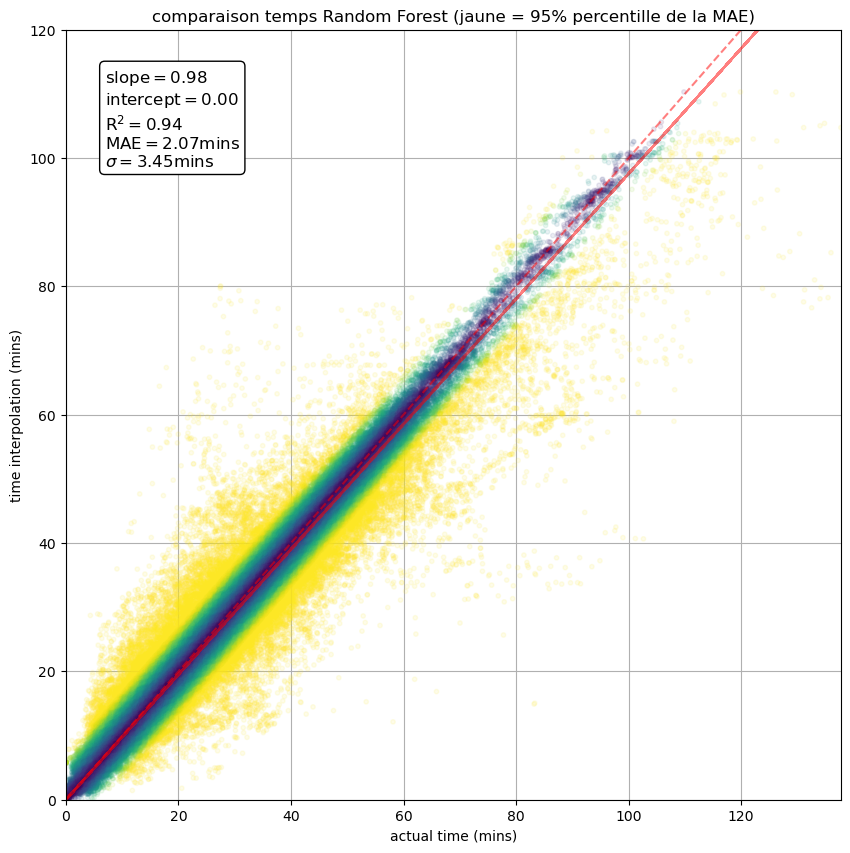

In [72]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=errors,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=errors.quantile(0.95), clip=True),
            alpha=0.1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
    r'$\mathrm{MAE}=%.2f$mins' % (np.mean(errors)/60, ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)
plt.xlim([0,120])
plt.ylim([0,120])
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps Random Forest (jaune = 95% percentille de la MAE)')


Text(0.5, 1.0, 'comparaison temps Random Forest (jaune = 95% percentille de la MAPE)')

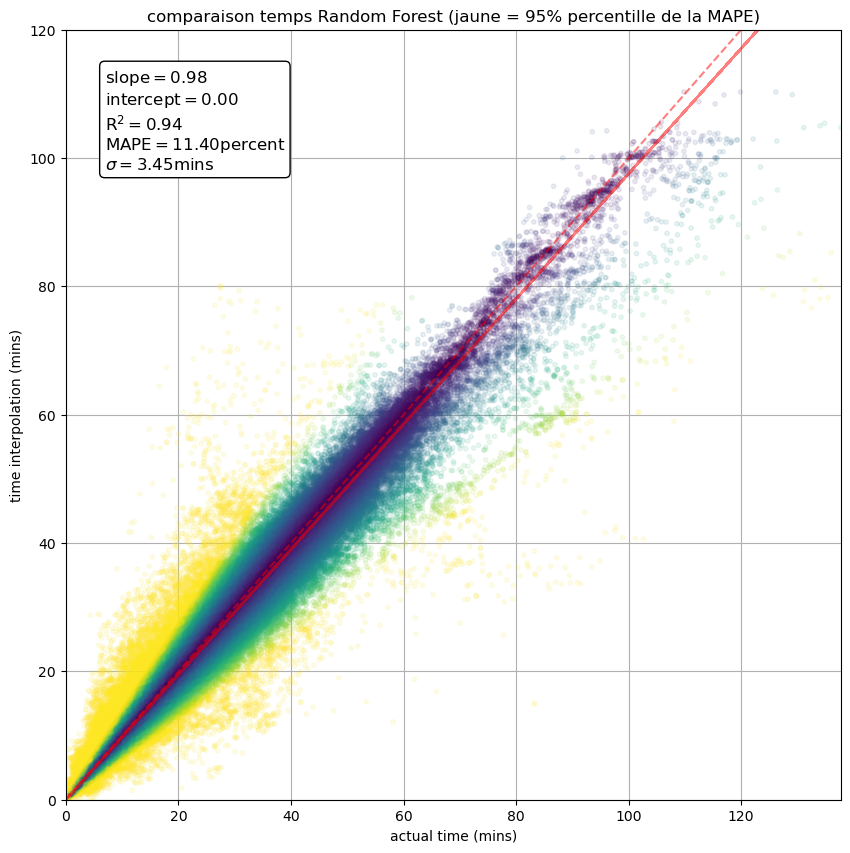

In [73]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=MAPE,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=MAPE.quantile(0.95), clip=True),
            alpha=0.1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
    r'$\mathrm{MAPE}=%.2f$percent' % (100*np.nanmean(MAPE[np.isfinite(MAPE)]), ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)
plt.xlim([0,120])
plt.ylim([0,120])
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps Random Forest (jaune = 95% percentille de la MAPE)')


In [74]:
#1) variogram 
#2) interp 4D scicpy
#3) Random Forrest avec plus de param.
#4) same mais avec les differences par rapport au model (vitesse moyenne, vitesse sur le reseau).

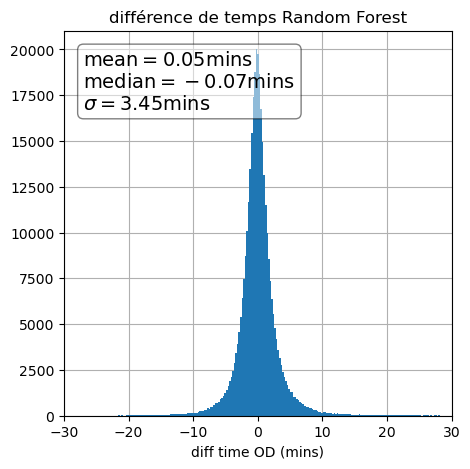

In [75]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(x-y,bins=500)
plt.xlabel('diff time OD (mins)')
mean = np.mean(x - y)
median = np.median(x - y)
sigma = np.std(x-y)
textstr = '\n'.join((
    r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([-30,30])
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title('différence de temps Random Forest')
#plt.title('différence de temps (best solution - quetzal) pour chaque OD' +city+relgap)


plt.show()

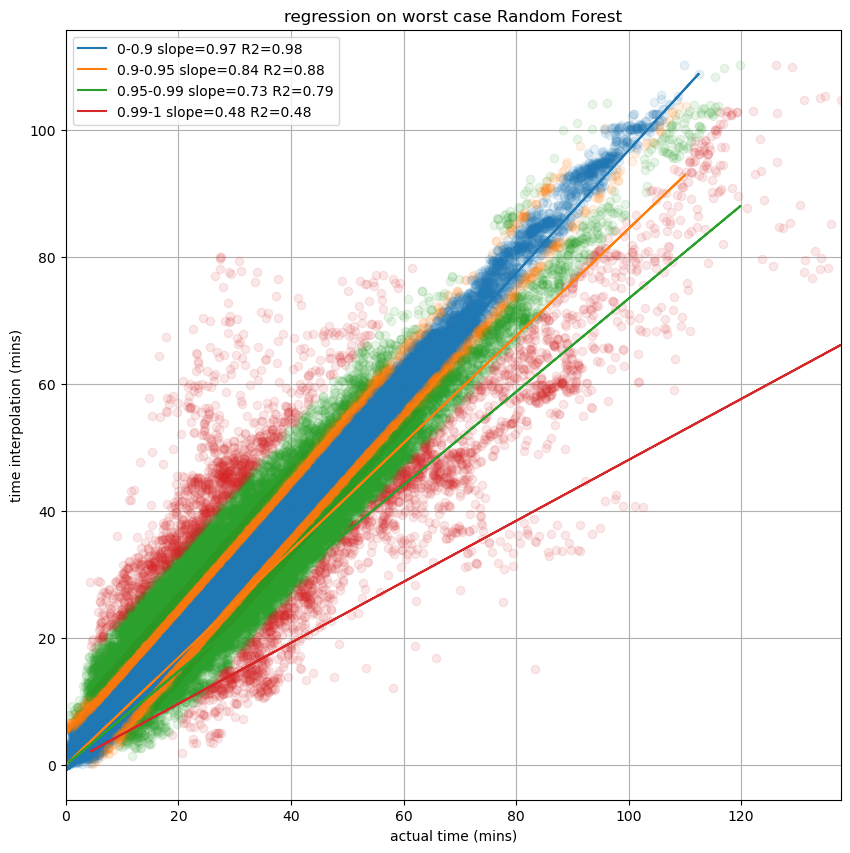

In [76]:

%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
quant = [0,0.9,0.95,0.99,1]
for i in range(len(quant)-1):
    cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
    yw = predictions[cond]/60
    xw = y_test[cond].values/60
    regr = linear_model.LinearRegression(fit_intercept=True)#
    regr.fit(xw[:, np.newaxis], yw)
    y_predw = regr.predict(xw[:, np.newaxis])
    r2 = r2_score(yw, y_predw)
    regr.fit(xw[:, np.newaxis], yw)
    slopew = regr.coef_[0]
    label = str(quant[i]) + '-'+ str(quant[i+1]) + ' slope='+str(round(slopew,2)) + ' R2=' +str(round(r2,2))
    metrics.loc['RF',str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
    metrics.loc['RF',str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)

    plt.scatter(xw,yw,alpha=0.1)
    line = plt.plot(xw,xw*slopew+intercept,alpha=1,label=label)
    #plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('regression on worst case Random Forest')
plt.legend()                    

# Linear model

In [77]:
from sklearn.linear_model import LinearRegression

In [78]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
MAPE = errors/y_test

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors)/60, 2), 'mins.')

Mean Absolute Error: 5.67 mins.


In [79]:
x = y_test.values/60
y = predictions/60

regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0



In [80]:
model_name = 'linear'
hdf[model_name] = x-y
sigma = np.std(x-y)
mean = np.mean(x - y)
median =np.median(x - y)

metrics.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
metrics.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
metrics.loc[model_name,'r2'] = r2
metrics.loc[model_name,'slope'] = slope
metrics.loc[model_name,'diff_mean'] = mean
metrics.loc[model_name,'diff_median'] = median
metrics.loc[model_name,'diff_STD'] = sigma

Text(0.5, 1.0, 'comparaison temps Linear Model(jaune = 5% des points)')

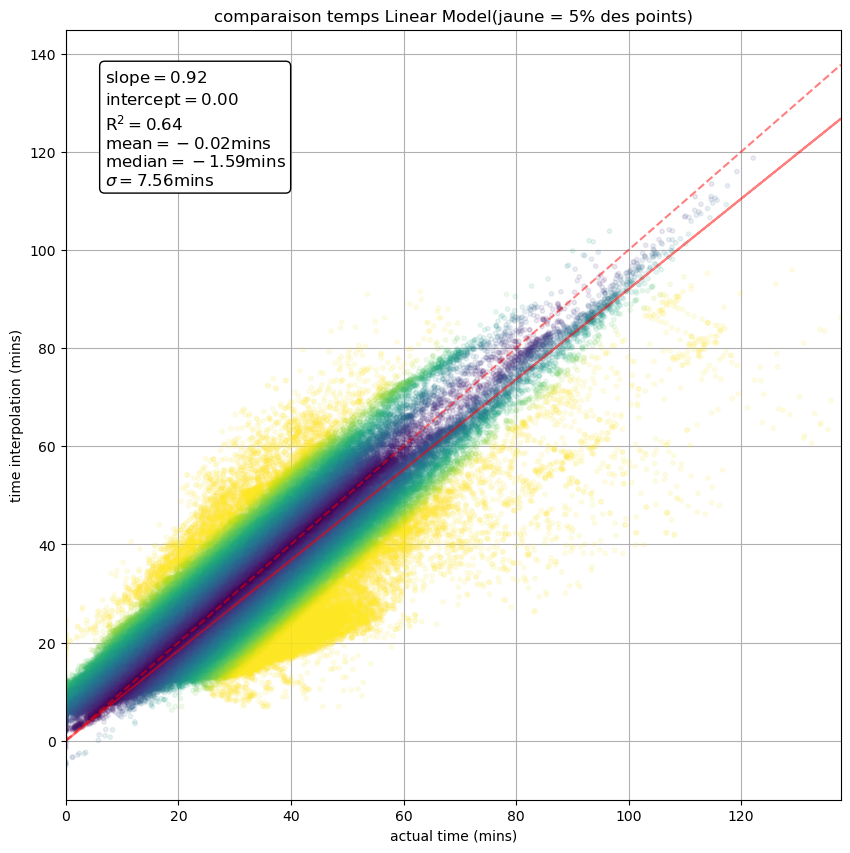

In [81]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=errors,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=errors.quantile(0.95), clip=True),
            alpha=0.1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
     r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps Linear Model(jaune = 5% des points)')


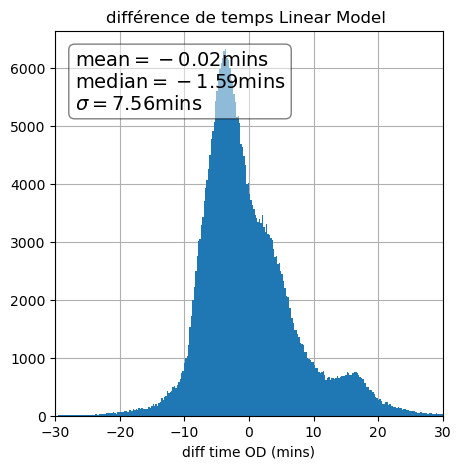

In [82]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(x-y,bins=500)
plt.xlabel('diff time OD (mins)')
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)
textstr = '\n'.join((
    r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([-30,30])
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title('différence de temps Linear Model ')
#plt.title('différence de temps (best solution - quetzal) pour chaque OD' +city+relgap)


plt.show()

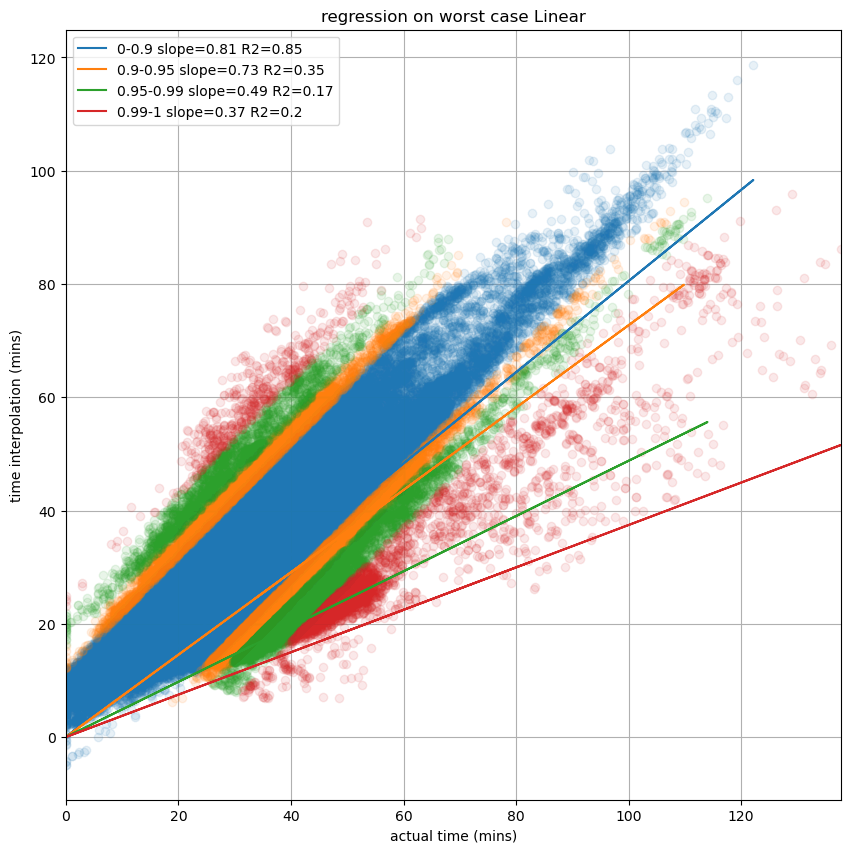

In [83]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
quant = [0,0.9,0.95,0.99,1]
for i in range(len(quant)-1):
    cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
    yw = predictions[cond]/60
    xw = y_test[cond].values/60
    regr = linear_model.LinearRegression(fit_intercept=True)#
    regr.fit(xw[:, np.newaxis], yw)
    y_predw = regr.predict(xw[:, np.newaxis])
    r2 = r2_score(yw, y_predw)
    regr.fit(xw[:, np.newaxis], yw)
    slopew = regr.coef_[0]
    label = str(quant[i]) + '-'+ str(quant[i+1]) + ' slope='+str(round(slopew,2)) + ' R2=' +str(round(r2,2))
    metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
    metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)

    plt.scatter(xw,yw,alpha=0.1)
    line = plt.plot(xw,xw*slopew+intercept,alpha=1,label=label)
    #plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('regression on worst case Linear')
plt.legend()      

# Polynomial

In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
model = make_pipeline(PolynomialFeatures(2), Ridge(alpha=1e-3))
model.fit(X_train, y_train)
predictions = model.predict(X_test)
errors = abs(predictions - y_test)
MAPE = errors/y_test

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors)/60, 2), 'mins.')

Mean Absolute Error: 5.14 mins.


In [41]:
x = y_test.values/60
y = predictions/60

regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0


In [42]:
model_name = 'poly'
hdf[model_name] = x-y
sigma = np.std(x-y)
mean = np.mean(x - y)
median =np.median(x - y)

metrics.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
metrics.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
metrics.loc[model_name,'r2'] = r2
metrics.loc[model_name,'slope'] = slope
metrics.loc[model_name,'diff_mean'] = mean
metrics.loc[model_name,'diff_median'] = median
metrics.loc[model_name,'diff_STD'] = sigma

Text(0.5, 1.0, 'comparaison temps Polynomial (2) (jaune = 5% des points)')

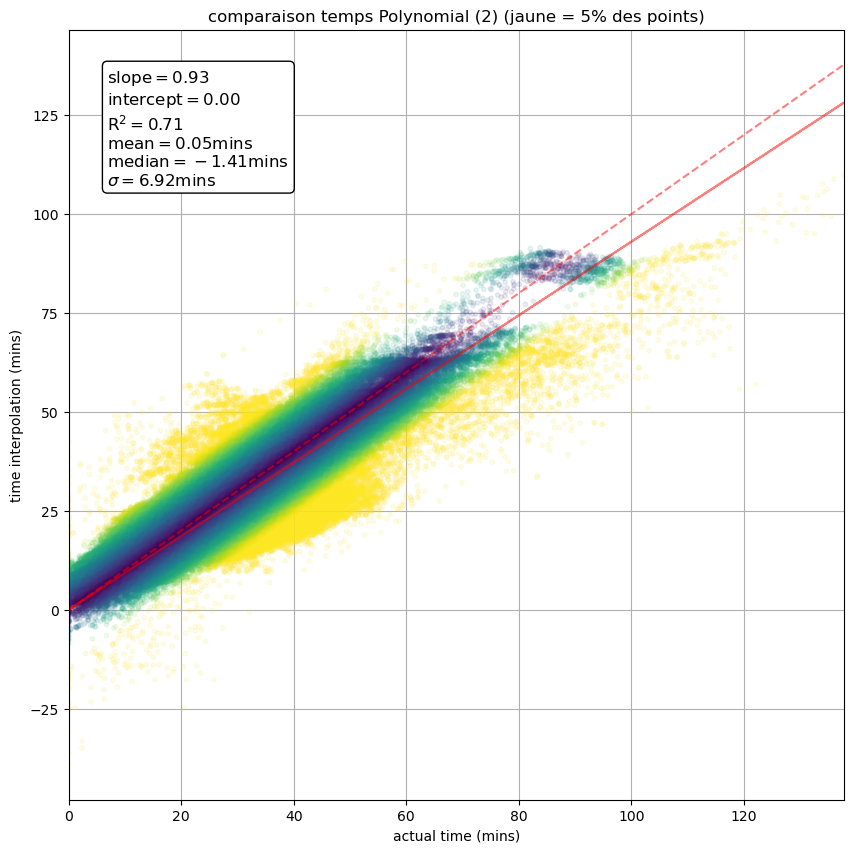

In [43]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=errors,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=errors.quantile(0.95), clip=True),
            alpha=0.1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
     r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps Polynomial (2) (jaune = 5% des points)')


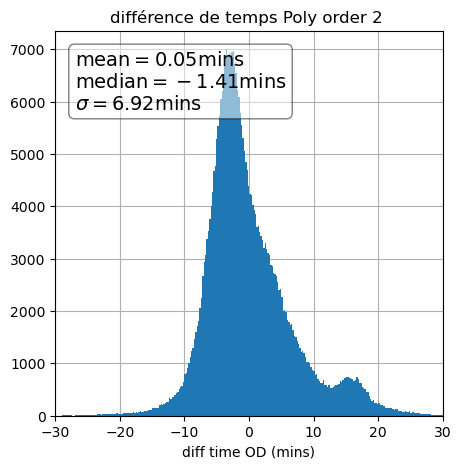

In [44]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(x-y,bins=500)
plt.xlabel('diff time OD (mins)')
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)
textstr = '\n'.join((
    r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([-30,30])
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title('différence de temps Poly order 2 ')
#plt.title('différence de temps (best solution - quetzal) pour chaque OD' +city+relgap)


plt.show()

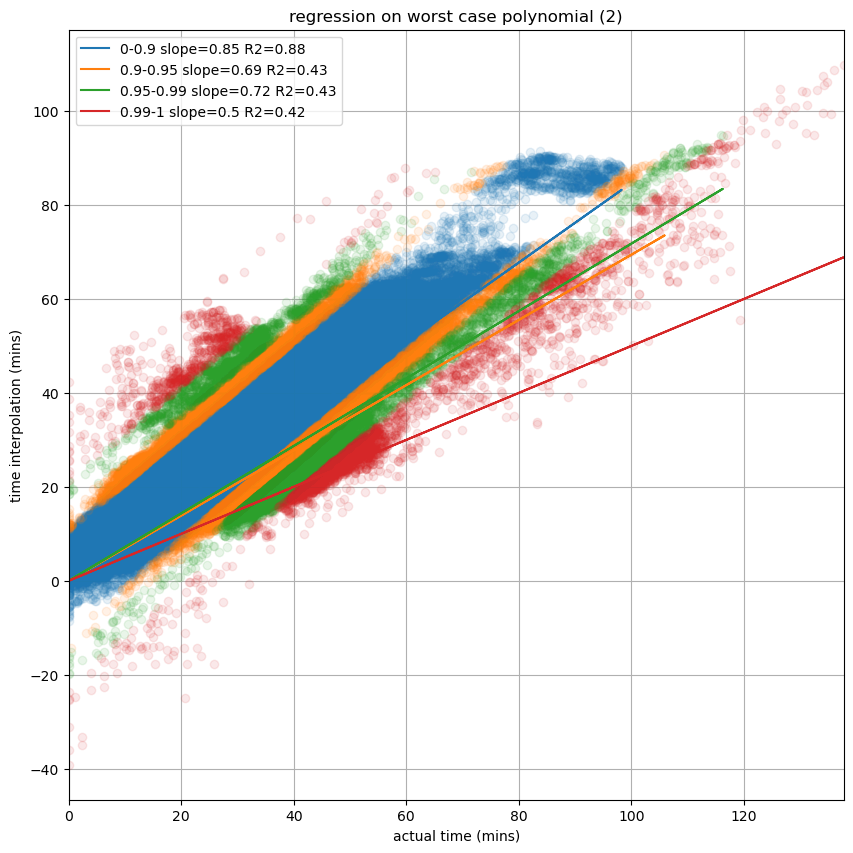

In [45]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
quant = [0,0.9,0.95,0.99,1]
for i in range(len(quant)-1):
    cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
    yw = predictions[cond]/60
    xw = y_test[cond].values/60
    regr = linear_model.LinearRegression(fit_intercept=False)#
    regr.fit(xw[:, np.newaxis], yw)
    y_predw = regr.predict(xw[:, np.newaxis])
    r2 = r2_score(yw, y_predw)
    regr.fit(xw[:, np.newaxis], yw)
    slopew = regr.coef_[0]
    label = str(quant[i]) + '-'+ str(quant[i+1]) + ' slope='+str(round(slopew,2)) + ' R2=' +str(round(r2,2))
    metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
    metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)

    plt.scatter(xw,yw,alpha=0.1)
    line = plt.plot(xw,xw*slopew+intercept,alpha=1,label=label)
    #plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('regression on worst case polynomial (2)')
plt.legend()      

# scipy interp griddata

In [46]:
from scipy.interpolate import griddata


In [47]:
predictions = griddata(X_train.values, y_train.values, X_test.values, method='nearest')
errors = abs(predictions - y_test)
MAPE = errors/y_test
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors)/60, 2), 'mins.')

Mean Absolute Error: 1.95 mins.


In [48]:
x = y_test.values/60
y = predictions/60

regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0


In [49]:
model_name = 'nearest'
hdf[model_name] = x-y
sigma = np.std(x-y)
mean = np.mean(x - y)
median =np.median(x - y)

metrics.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
metrics.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
metrics.loc[model_name,'r2'] = r2
metrics.loc[model_name,'slope'] = slope
metrics.loc[model_name,'diff_mean'] = mean
metrics.loc[model_name,'diff_median'] = median
metrics.loc[model_name,'diff_STD'] = sigma


Text(0.5, 1.0, 'comparaison temps Nearest (jaune = 5% des points)')

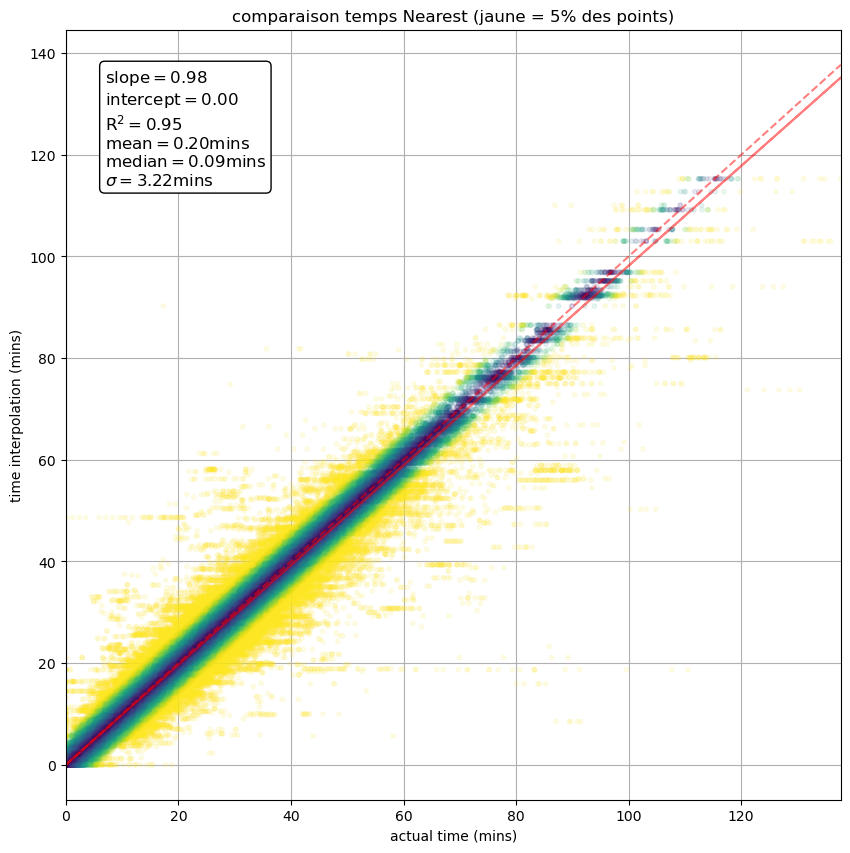

In [50]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=errors,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=errors.quantile(0.95), clip=True),
            alpha=0.1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
     r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps Nearest (jaune = 5% des points)')


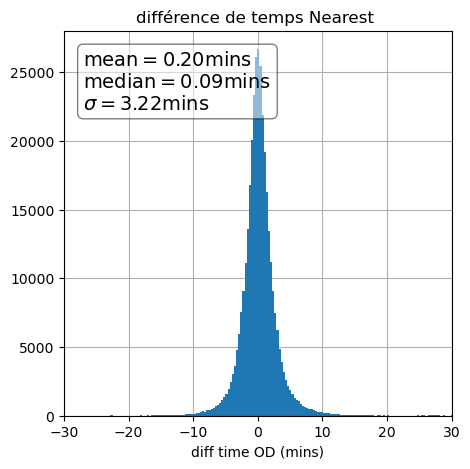

In [51]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(x-y,bins=500)
plt.xlabel('diff time OD (mins)')
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)
textstr = '\n'.join((
    r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([-30,30])
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title('différence de temps Nearest ')
#plt.title('différence de temps (best solution - quetzal) pour chaque OD' +city+relgap)


plt.show()

Text(0.5, 1.0, 'comparaison temps Nearest (jaune = 95% percentille de la MAPE)')

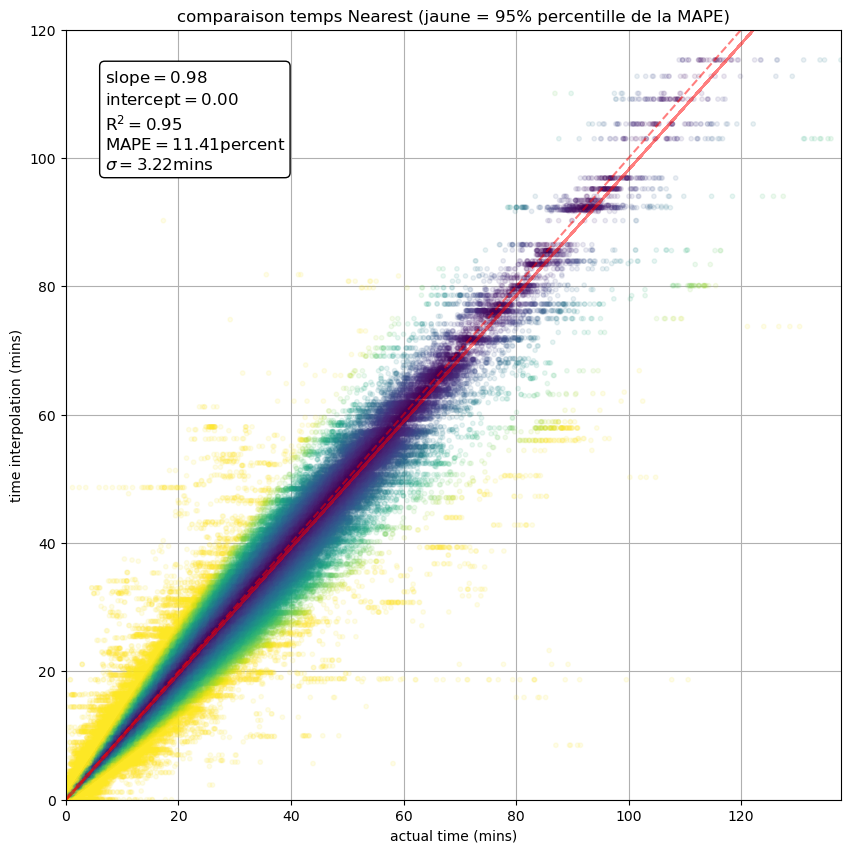

In [52]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=MAPE,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=MAPE.quantile(0.95), clip=True),
            alpha=0.1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
    r'$\mathrm{MAPE}=%.2f$percent' % (100*np.nanmean(MAPE[np.isfinite(MAPE)]), ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)
plt.xlim([0,120])
plt.ylim([0,120])
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps Nearest (jaune = 95% percentille de la MAPE)')


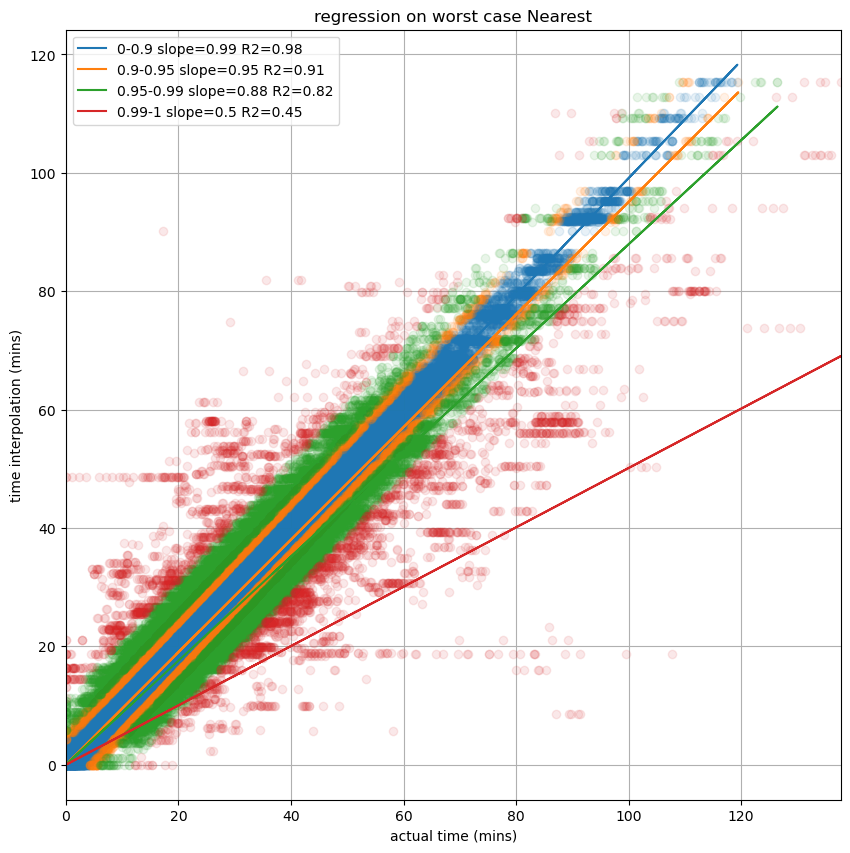

In [53]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
quant = [0,0.9,0.95,0.99,1]
for i in range(len(quant)-1):
    cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
    yw = predictions[cond]/60
    xw = y_test[cond].values/60
    regr = linear_model.LinearRegression(fit_intercept=True)#
    regr.fit(xw[:, np.newaxis], yw)
    y_predw = regr.predict(xw[:, np.newaxis])
    r2 = r2_score(yw, y_predw)
    regr.fit(xw[:, np.newaxis], yw)
    slopew = regr.coef_[0]
    label = str(quant[i]) + '-'+ str(quant[i+1]) + ' slope='+str(round(slopew,2)) + ' R2=' +str(round(r2,2))
    metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
    metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)

    plt.scatter(xw,yw,alpha=0.1)
    line = plt.plot(xw,xw*slopew+intercept,alpha=1,label=label)
    #plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('regression on worst case Nearest')
plt.legend()      

# KNN

In [54]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(weights='distance',algorithm='ball_tree', n_neighbors=5,)
neigh.fit(X_train.values, y_train.values)

KNeighborsRegressor(algorithm='ball_tree', weights='distance')

In [55]:
predictions = neigh.predict(X_test.values)
errors = abs(predictions - y_test)
MAPE = errors/y_test

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors)/60, 2), 'mins.')

Mean Absolute Error: 1.75 mins.


In [56]:
x = y_test.values/60
y = predictions/60
regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0


In [57]:
model_name = 'KNN'
hdf[model_name] = x-y
sigma = np.std(x-y)
mean = np.mean(x - y)
median =np.median(x - y)

metrics.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
metrics.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
metrics.loc[model_name,'r2'] = r2
metrics.loc[model_name,'slope'] = slope
metrics.loc[model_name,'diff_mean'] = mean
metrics.loc[model_name,'diff_median'] = median
metrics.loc[model_name,'diff_STD'] = sigma

Text(0.5, 1.0, 'comparaison temps KNN (jaune = 5% des points)')

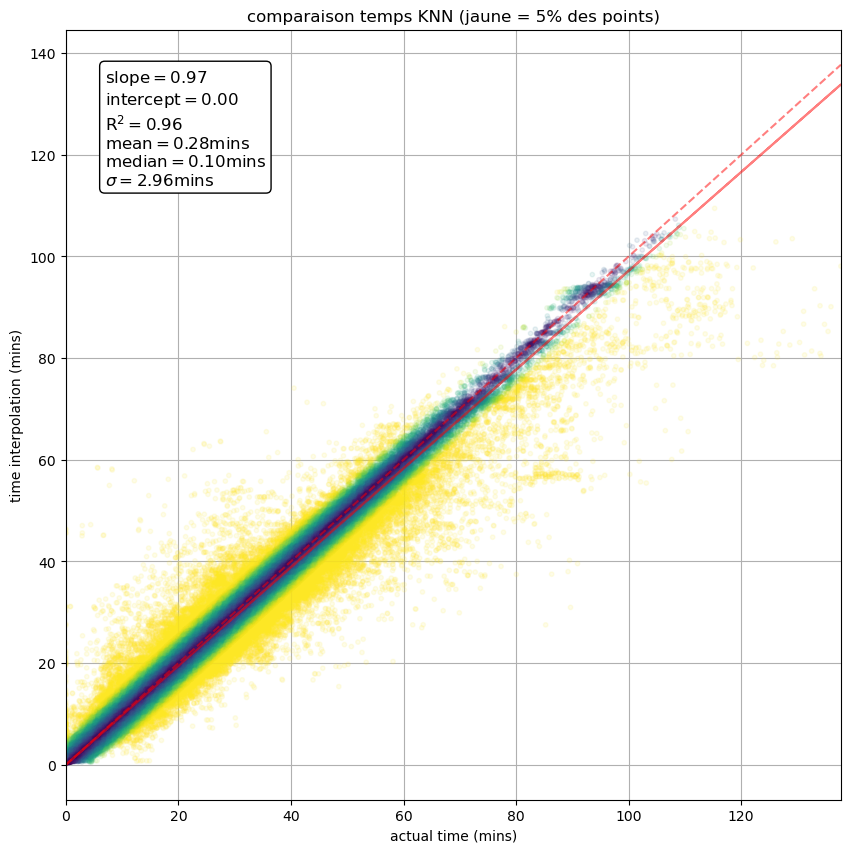

In [58]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=errors,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=errors.quantile(0.95), clip=True),
            alpha=0.1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
     r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps KNN (jaune = 5% des points)')


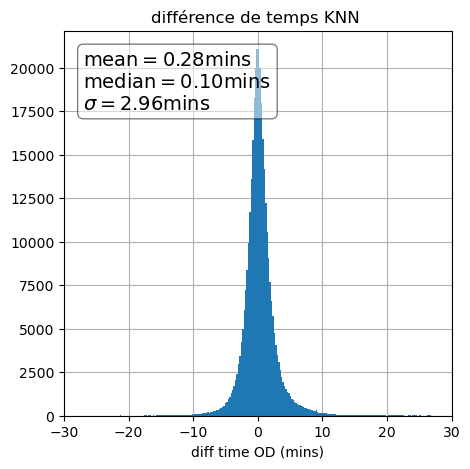

In [59]:
fig, ax = plt.subplots(figsize=(5,5))
plt.hist(x-y,bins=500)
plt.xlabel('diff time OD (mins)')
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)
textstr = '\n'.join((
    r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([-30,30])
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title('différence de temps KNN ')
#plt.title('différence de temps (best solution - quetzal) pour chaque OD' +city+relgap)


plt.show()

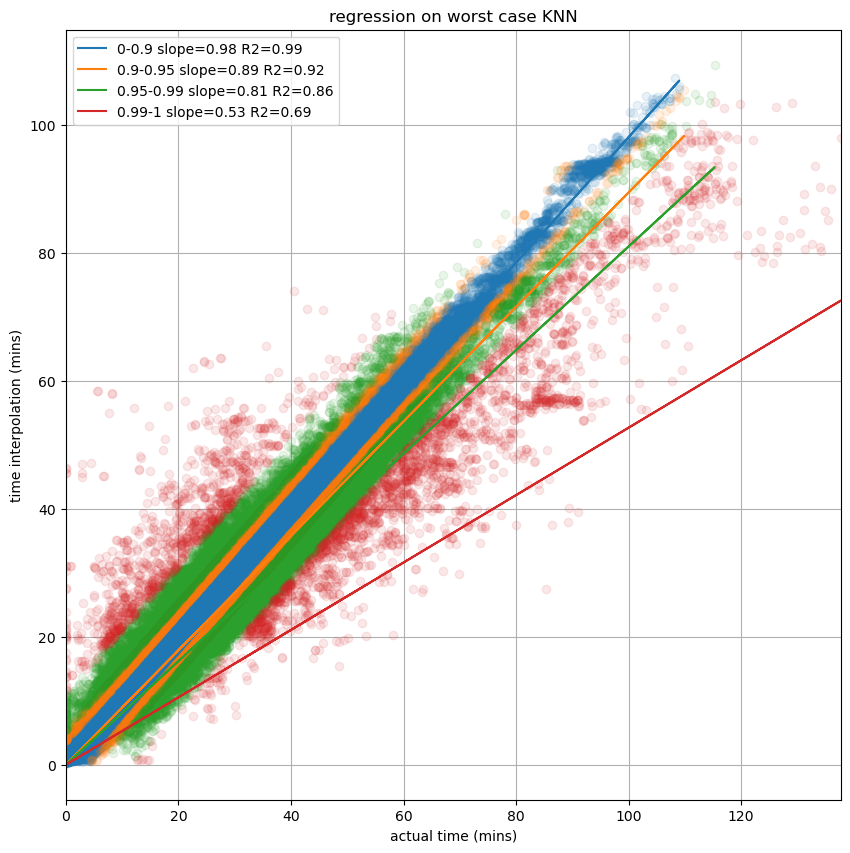

In [60]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
quant = [0,0.9,0.95,0.99,1]
for i in range(len(quant)-1):
    cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
    yw = predictions[cond]/60
    xw = y_test[cond].values/60
    regr = linear_model.LinearRegression(fit_intercept=True)#
    regr.fit(xw[:, np.newaxis], yw)
    y_predw = regr.predict(xw[:, np.newaxis])
    r2 = r2_score(yw, y_predw)
    regr.fit(xw[:, np.newaxis], yw)
    slopew = regr.coef_[0]
    label = str(quant[i]) + '-'+ str(quant[i+1]) + ' slope='+str(round(slopew,2)) + ' R2=' +str(round(r2,2))
    metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
    metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)

    plt.scatter(xw,yw,alpha=0.1)
    line = plt.plot(xw,xw*slopew+intercept,alpha=1,label=label)
    #plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('regression on worst case KNN')
plt.legend()      

# comparaison 

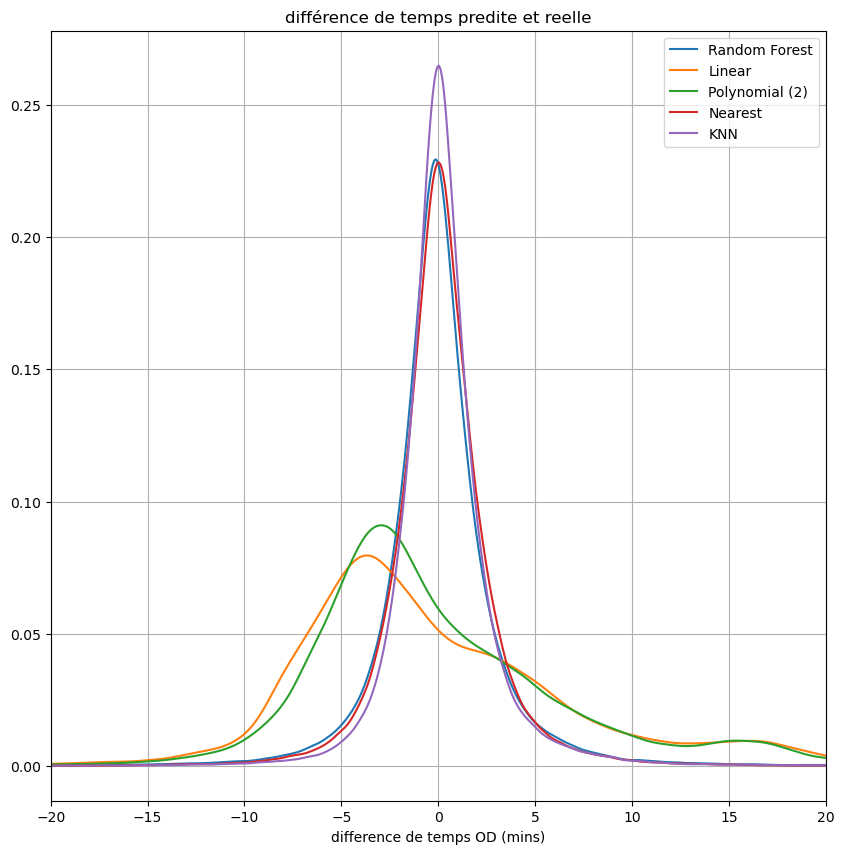

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
import scipy.stats as stats
x=np.linspace(-20, 20, 500)
for name in hdf.columns:
    density = stats.gaussian_kde(hdf[name])
    plt.plot(x,density(x))
plt.legend(['Random Forest','Linear','Polynomial (2)','Nearest','KNN'])
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([-20,20])
plt.xlabel('difference de temps OD (mins)')

plt.title('différence de temps predite et reelle')
plt.show()

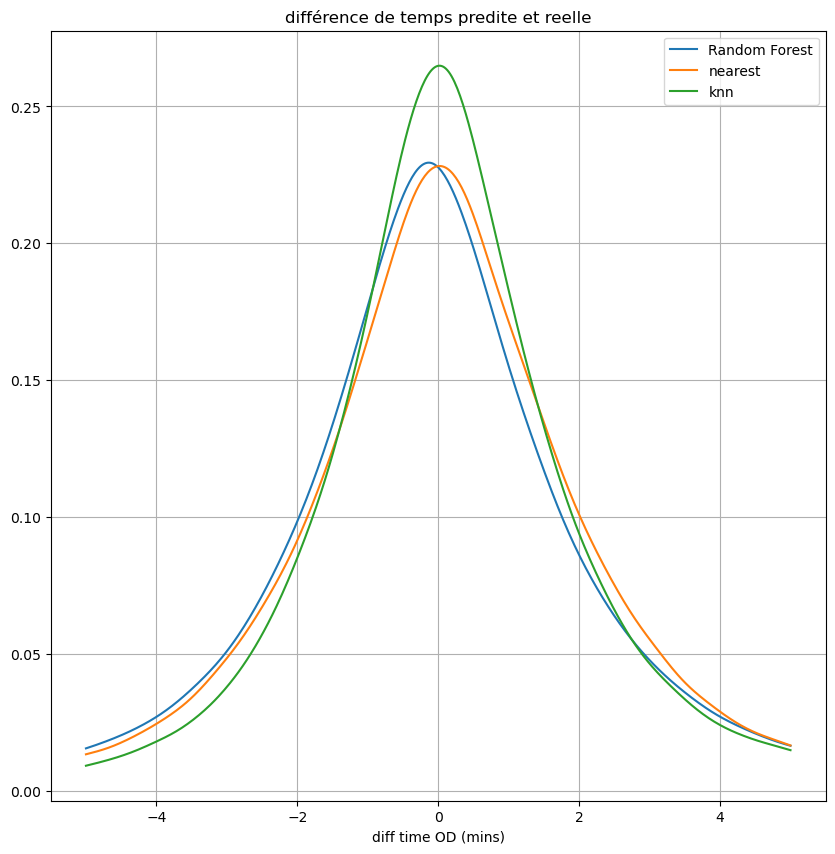

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
x=np.linspace(-5, 5, 500)
for name in ['rf','nearest','KNN']:
    density = stats.gaussian_kde(hdf[name])
    plt.plot(x,density(x))
plt.legend(['Random Forest','nearest','knn'])
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlabel('diff time OD (mins)')

plt.title('différence de temps predite et reelle')
plt.show()

In [63]:
metrics = metrics.loc[['linear','poly','RF','nearest','KNN']]
metrics

MAE       MAPE        r2     slope  diff_mean  diff_median  \
linear   5.67  39.609779  0.635068  0.920143  -0.021195    -1.588015   
poly     5.14  33.930859  0.709812  0.930116   0.050585    -1.413808   
RF       2.07  11.397833  0.937809  0.975664   0.051814    -0.073558   
nearest  1.95  11.411153  0.948697  0.981753   0.195105     0.089184   
KNN      1.75  10.061958  0.955635  0.971803   0.279878     0.103074   

         diff_STD  0-0.9-slope  0-0.9-r2  0.9-0.95-slope  0.9-0.95-r2  \
linear   7.556747     0.805169      0.85        0.727197         0.35   
poly     6.918295     0.847434      0.88        0.694727         0.43   
RF       3.450188     0.968093      0.98        0.844580         0.88   
nearest  3.224468     0.991071      0.98        0.950819         0.91   
KNN      2.961112     0.981480      0.99        0.894944         0.92   

         0.95-0.99-slope  0.95-0.99-r2  0.99-1-slope  0.99-1-r2  
linear          0.487843          0.17      0.374411       0.20  
poly            0.718263          0.43      0.500346       0.42  
RF              0.734397          0.79      0.480316       0.48  
nearest         0.879320          0.82      0.501295       0.45  
KNN             0.810526          0.86      0.527097       0.69

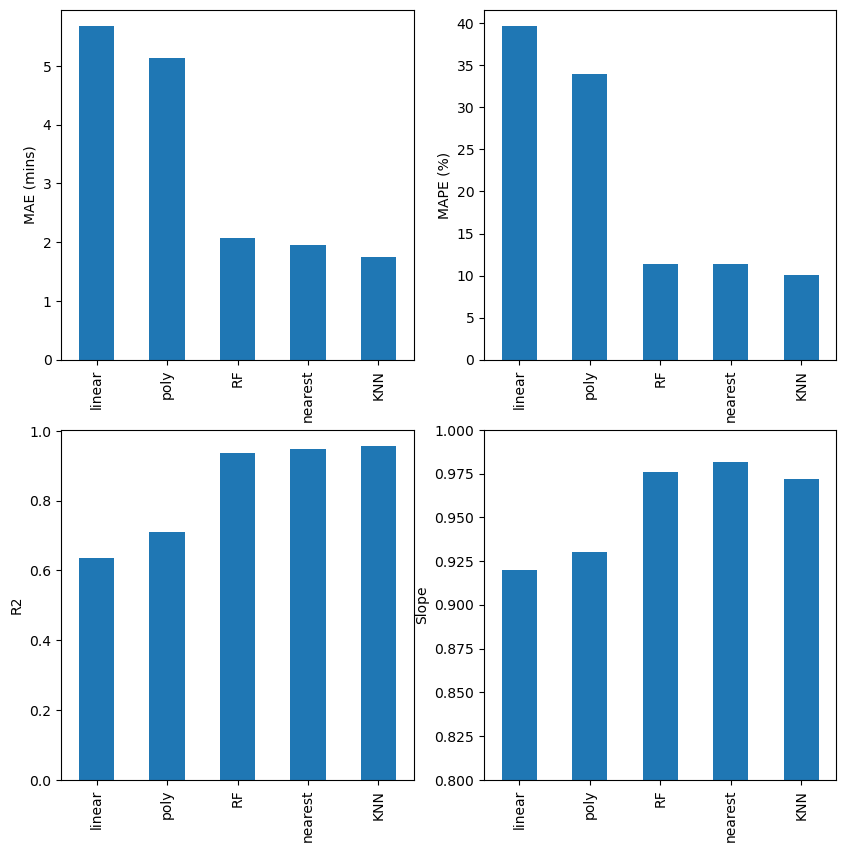

In [64]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metrics['MAE'].plot(kind='bar',ax=ax[0,0],ylabel='MAE (mins)')
metrics['MAPE'].plot(kind='bar',ax=ax[0,1],ylabel='MAPE (%)')
metrics['r2'].plot(kind='bar',ax=ax[1,0],ylabel='R2')
metrics['slope'].plot(kind='bar',ax=ax[1,1],ylabel='Slope',ylim=[0.8,1])
plt.show()

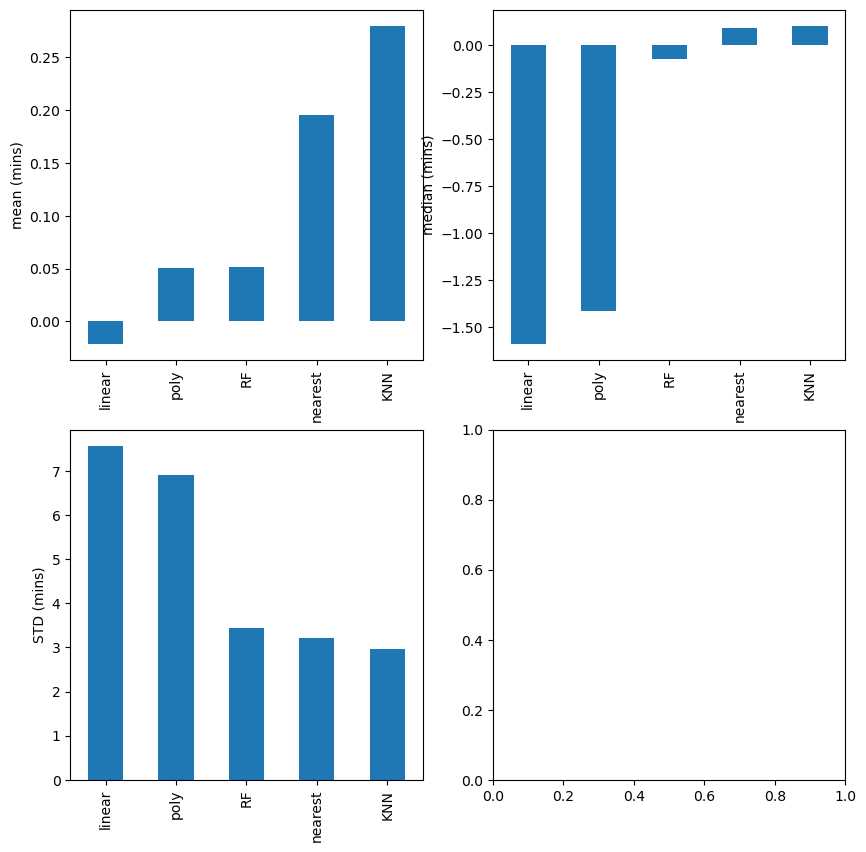

In [65]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metrics['diff_mean'].plot(kind='bar',ax=ax[0,0],ylabel='mean (mins)')
metrics['diff_median'].plot(kind='bar',ax=ax[0,1],ylabel='median (mins)')
metrics['diff_STD'].plot(kind='bar',ax=ax[1,0],ylabel='STD (mins)')
plt.show()

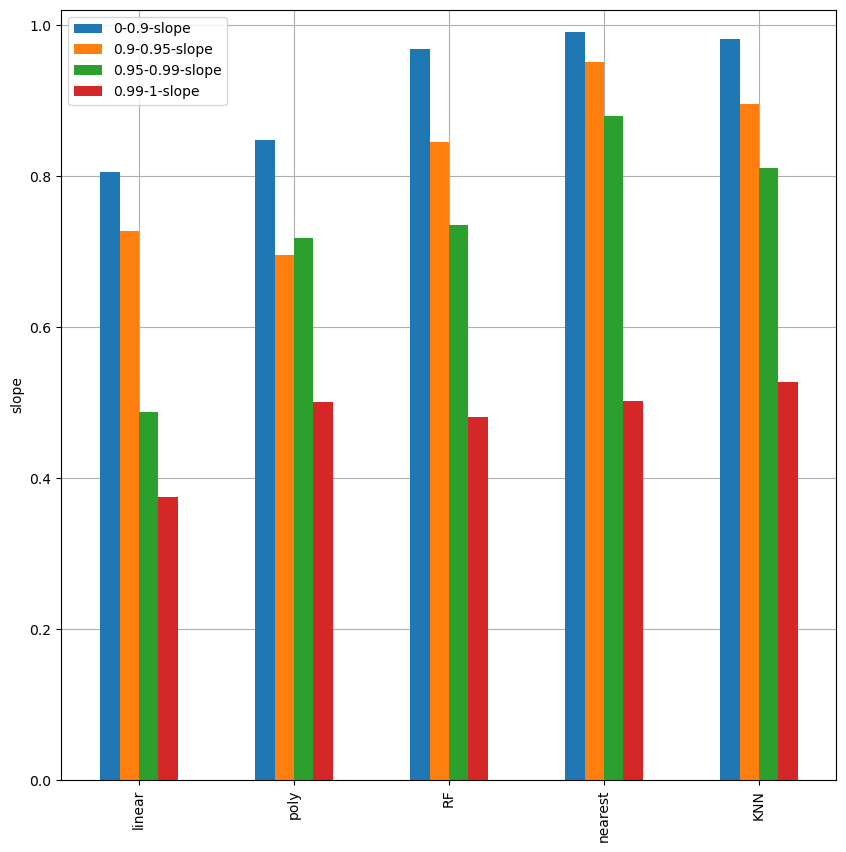

In [66]:
fig, ax = plt.subplots(figsize=(10,10))

metrics[metrics.columns[['-slope' in col for col in metrics.columns]]].plot(ax=ax,kind='bar',ylim=[0,1.02],ylabel='slope')
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)

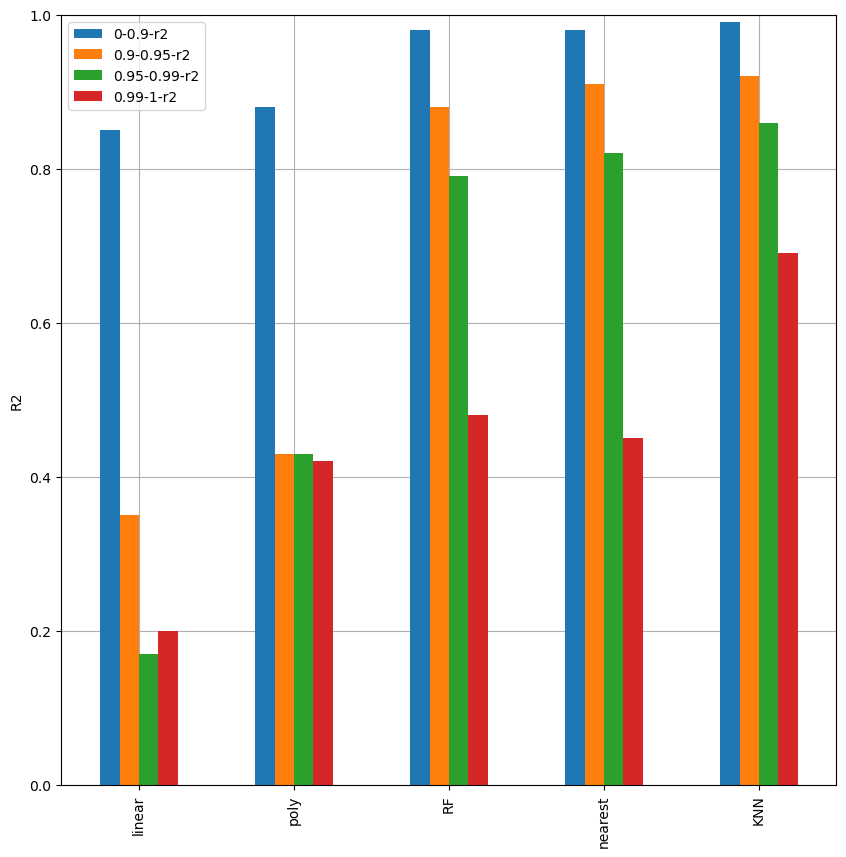

In [67]:
fig, ax = plt.subplots(figsize=(10,10))

metrics[metrics.columns[['-r2' in col for col in metrics.columns]]].plot(ax=ax,kind='bar',ylim=[0,1],ylabel='R2')
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)

In [623]:
wcond = errors[errors>2000]
df = od_time_quebec.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'time'})
ori = df.loc[wcond.index]['origin'].values
des = df.loc[wcond.index]['destination'].values

In [624]:
nodes_test = nodes_tot

<IPython.core.display.Javascript object>


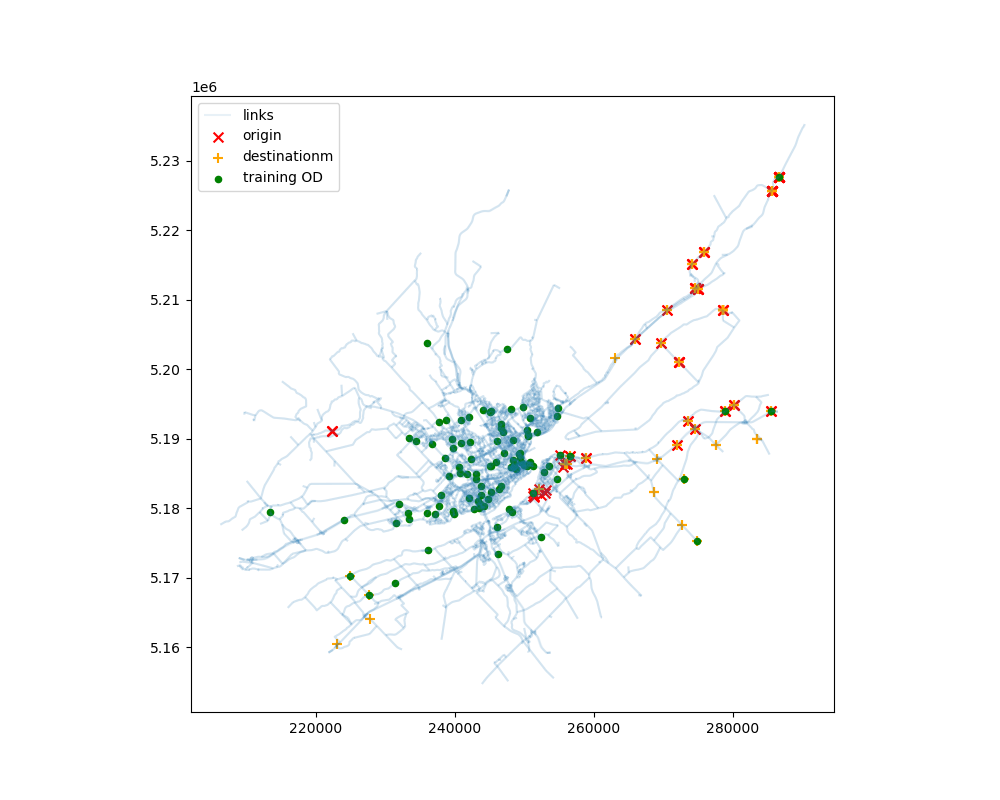

In [625]:
%matplotlib notebook
f, ax = plt.subplots(figsize=(10,8))
links.plot(ax=ax,alpha=0.1)
nodes_test.loc[ori].plot(ax=ax,color='red',marker='x',markersize=50)
nodes_test.loc[des].plot(ax=ax,color='orange',marker='+',markersize=50)
nodes_train.plot(ax=ax,color='g',markersize=20)
plt.legend(['links','origin','destinationm','training OD'])

Mean Absolute Error: 0.0 mins.


TypeError: RegressorMixin.score() missing 2 required positional arguments: 'X' and 'y'

Mean Absolute Error: 0.0 mins.


Text(0.5, 1.0, 'comparaison temps KNN (jaune = 5% des points)')

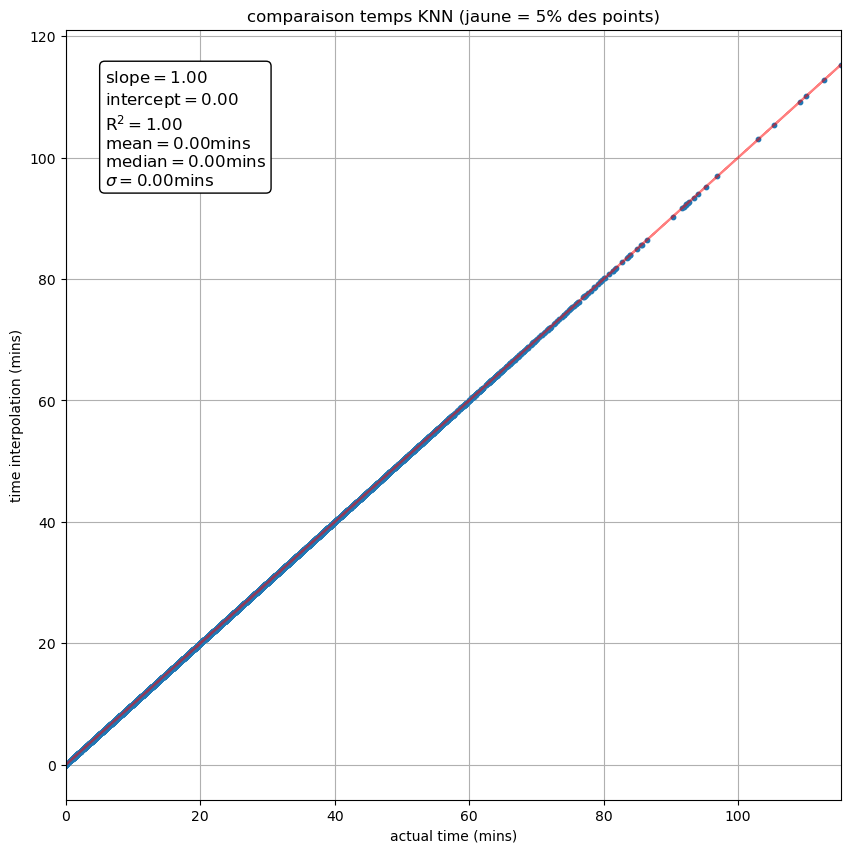

In [634]:
%matplotlib inline
predictions = neigh.predict(X_train.values)
errors = abs(predictions - y_train)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors)/60, 2), 'mins.')
x = y_train.values/60
y = predictions/60
regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0

fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            alpha=1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0)
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
     r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps KNN (jaune = 5% des points)')
